![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (12, 6)

In [20]:
kf = 1.e-9
mu = 1.e-3
g = 9.81
rho = 1000.
k = kf*mu/(rho*g)
print(k)

1.0193679918450563e-16


# Exercise 7 - 1D Consolidation, Terzaghi. Influence of mass lumping and FIC stabilization

## Governing differential equation

Neglecting lateral displacements and fluid flow

$$
	\epsilon_{xx} = \epsilon_{yy} = 0 \quad \text{and} \quad q_x = q_y = 0
$$

the volume balance simplifies to

$$
	\dot{\epsilon}_{zz} = \frac{\partial q_z}{\partial z}
$$

Now we substitute the constitutive law (linear elasticity) of the solid and Darcy's law for the fluid motion into the volume balance and get

$$
    \dot{\sigma}_{zz}^\text{eff} = E_\text{S} \dot{\epsilon}_{zz} \quad \text{and} \quad \frac{\partial q_z}{\partial z} = - \frac{k}{\mu_\text{F}} \frac{\partial^2 p}{\partial z^2} \quad \text{ergibt} \quad		
		 \frac{\dot{\sigma}_{zz}^\text{eff}}{E_\text{S}} = - \frac{k}{\mu_\text{F}} \frac{\partial^2 p}{\partial z^2}
$$

Assuming constant total stress (constant external loads) we find with the use of the effective stress principle

$$
	\sigma_{zz} = \sigma_{zz}^\text{eff} + p = \text{const} \quad \rightarrow \quad \dot{\sigma}_{zz} = 0 = \dot{\sigma}_{zz}^\text{eff} + \dot{p}
$$

Substitution yields the partial, linear and homogeneous differential equation

$$
	\dot{p} = \frac{E_\text{S} k}{\mu_\text{F}} p_{,zz} = \frac{E_\text{S} K_\text{D}}{\gamma_\text{F}} p_{,zz} = C_\text{V} p_{,zz} \quad \text{with } K_\text{D} = \frac{k\rho_\text{F} g}{\mu_\text{F}}
$$

$[k] = \text{m}^2$: intrinsic permeability

$[K_\text{D}] = \text{m s}^{-1}$: hydraulic conductivity

$[C_\text{V}] = \text{m}^2\text{s}^{-1}$: coefficient of consolidation


## Weak form

The pore pressure can have (the essential/Dirichlet) boundary conditions in the form:

$$
    p = \bar{p}\ \forall z \in \partial \Omega_\mathrm{D}
$$

We now introduce a test function $\eta$ which vanishes where the pore pressure is given

$$
    \eta = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \eta \left[\dot{p} - C_\text{V} p_{,zz} \right] \text{d}z
   \\
   &= \int \limits_0^H \left[\eta \dot{p} - \left( \eta C_\text{V} p_{,z} \right)_{,z} + \eta_{,z} C_\text{V} p_{,z} \right] \, \text{d}z
   \\
   &= \int \limits_0^H \left[\eta \dot{p} + \eta_{,z} C_\text{V} p_{,z} \right] \, \text{d}z + \left[ \eta E_\text{S} q_z \right]^H_0
\end{align}

where the natural/Neumann boundary conditions have appeared.

## Finite elements in 1D

We have a soil column of height $H$ on top of the bed rock at $z=0$.

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [21]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [22]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_mesh(domain_length,nelems,nodes_per_elem):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         list(range(node_start,node_start+nodes_per_elem))))
        
    return global_nodal_coordinates, element_vector, global_solution

## Shape functions in 1D

As in exercise 06, we allow linear and higher-order shape functions.

In [23]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5*xi/xi, 0.5*xi/xi])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


## Time and space discretization, Picard iterations

Using a backward Euler approach for simplicity we find the time-discrete weak form as ($p_{n+1} \equiv p$)

$$
    0 = \int \limits_0^H \left[\eta \frac{p - p_n}{\Delta t} + \eta_{,z} C_\text{V} p_{,z} \right] \, \text{d}z + \left[ \eta E_\text{S} q_z \right]^H_0
$$

Introducing standard FE approximations

$$
    p \approx N_i \hat{p}_i, \quad \eta \approx N_i \hat{\eta}_i, \quad \frac{\partial p}{\partial z} \approx \nabla  N_i \hat{p}_i, \quad \frac{\partial \eta}{\partial z} \approx \nabla N_i \hat{\eta}_i
$$

This yields

$$
\begin{align}
 0 &= \int \limits_0^H \left[ N_i \hat{\eta}_i \frac{N_k \hat{p}_k - N_k \hat{p}_{n,k}}{\Delta t} + \nabla N_i \hat{\eta}_i C_\text{V} \nabla N_k \hat{p}_k \right] \, \text{d}z + \left[ N_i \hat{\eta}_i E_\text{S} q_z \right]^H_0
 \end{align}
$$

Now we bring all quantities associated with the unknown pressure to the left-hand side (LHS) and all known quantities to the RHS:

$$
    \hat{\eta}_i \int \limits_0^H \left[ N_i \frac{1}{\Delta t} N_k + \nabla N_i C_\text{V} \nabla  N_k \right] \, \text{d}z\ \hat{p}_k =  \hat{\eta}_i \left[ N_{n_\text{n}} E_\text{S} \bar{q}_z|_{z=H} \delta_{n_\text{n}i} - N_{n_\text{n}} E_\text{S} \bar{q}_z|_{z=0} \delta_{i0} \right] +  \hat{\eta}_i \int \limits_0^H N_i \frac{1}{\Delta t} N_k \, \text{d}z\ \hat{p}_{n,k}
$$

can be simplified by realizing that the nodal test function values are arbitrary and thus

$$
    \int \limits_0^H \left[ N_i \frac{1}{\Delta t} N_k + \nabla N_i C_\text{V} \nabla N_k \right] \, \text{d}z\ \hat{p}_k = N_{n_\text{n}} E_\text{S} \bar{q}_z|_{z=H} \delta_{n_\text{n}i} - N_{n_\text{n}} E_\text{S} \bar{q}_z|_{z=0} \delta_{i0} +  \int \limits_0^H N_i \frac{1}{\Delta t} N_k \, \text{d}z\ \hat{p}_{n,k}
$$

which leaves us with $n_\text{n}$ equations for the $n_\text{n}$ unknown nodal pressures $\hat{p}_k$. If any coefficients in the above are taken as pressure-dependent, the system could be solved repeatedly usind Picard iterations. For strong non-linearities, a Newton linearization would typically be used.

### Question:

How would the equation differ for an explicit time integration scheme (forward Euler)?

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [24]:
def Stiffness(z):
    E0 = 5.e6 #Pa
    return E0

def Conductivity(z):
    kf = 1.e-9#m/s
    return kf

def SpecificWeight(z):
    g = 9.81 #m/s²
    rhow = 1000. #kg/m³
    return g*rhow

def ConsolidationCoeff(z):#m²/s
    return Stiffness(z)*Conductivity(z)/SpecificWeight(z)

In [25]:
def local_assembler(elem,dt,prev_sol,mass_lumping=False,stabilization=False):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    M_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        #evaluation of local body force
        CV = ConsolidationCoeff(z_glob)
        
        #assembly of local stiffness matrix
        M_loc = np.outer(N,N) / dt
        if (stabilization):
            #Stabilization term 1
            M_loc -= np.outer(N,dN_dX) * 0.5 * (z_nodes[-1] - z_nodes[0]) / dt
        if (mass_lumping):
            M_loc = np.diag(M_loc.sum(0)) #diagonal of column sum
           
        K_loc += (np.outer(dN_dX,dN_dX) * CV + M_loc)* w * detJ
        
        #assembly of local RHS
        p_prev = np.dot(N,prev_sol)#pressure in integration point
        b_loc += N * p_prev/dt * w * detJ
        if (stabilization):
            grad_p_prev = np.dot(dN_dX,prev_sol)#pressure gradient in integration point
            #Stabilization term 2
            b_loc -= N * grad_p_prev/dt * w * detJ * 0.5 * (z_nodes[-1] - z_nodes[0])
    return K_loc,b_loc

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [26]:
def global_assembler(nodes,elements,solution,dt,mass_lumping=False,stabilization=False):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        start_id = elem._line_element__global_ids[0]
        end_id = elem._line_element__global_ids[-1]
        K_i, b_i = local_assembler(elem,dt,solution[start_id:end_id+1],mass_lumping,stabilization)
        K_glob[start_id:end_id+1,start_id:end_id+1] += K_i
        b_glob[start_id:end_id+1] += b_i
    return K_glob, b_glob

## Application of boundary conditions

First we apply flux boundary conditions

In [27]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

Then we apply Dirichlet bc

In [28]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = 0.# = K_glob[:,node_id] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

## Application of initial conditions

Since we're dealing with a time-dependent problem (rate problem) we require initial conditions for the pore pressure, i.e. $p_0 = p(t=0)\ \forall\ z$. Due to the very specific assumptions in deriving this consolidation equation, the initial pressure is given by the (suddenly) applied load:

$$
    p_0 = \sigma_{zz} = \text{const.}
$$

In [29]:
def apply_initial_conditions(solution,sig_v):
    solution *= 0.
    solution += sig_v
    return

## Time loop and problem solution

We now establish the time loop and in each time step perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

In [30]:
def time_loop(dt,nodes,elements,solution,mass_lumping=False,stabilization=False):
    #Startwerte
    t_end = 366*24*60*60 #s
    absolute_tolerance = 1.e-6
    max_iter = 100
    iteration_counter = np.array([0])
    apply_initial_conditions(solution,200.e3)
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    #
    while times[-1]+dt < t_end: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            K, f = global_assembler(nodes,elements,y[-1],dt,mass_lumping,stabilization)
            #f = apply_Neumann_bc(f,len(nodes)-1,0)
            K, f = apply_Dirichlet_bc(K, f, len(nodes)-1, 0.)#free draining top
            solution = np.linalg.solve(K,f)
            i += 1
            if (np.abs(np.linalg.norm(solution) - np.linalg.norm(y_old)) < absolute_tolerance or i > max_iter): #if change is below tolerance, stop iterations
                break
            y_old = solution #preparation of next recursion

        y.append(solution) #append the new found solution to the solution vector
        iteration_counter = np.append(iteration_counter,i) #store how much iterations this time step took to converge
    return times, y,iteration_counter

In [31]:
#spatial discretization
H = 10.
nel = 20
n_per_el = 3
nodes,elements,solution=generate_mesh(H,nel,n_per_el)


In [32]:
times, sols, iters = time_loop(24*60*60,nodes,elements,solution,False,False)

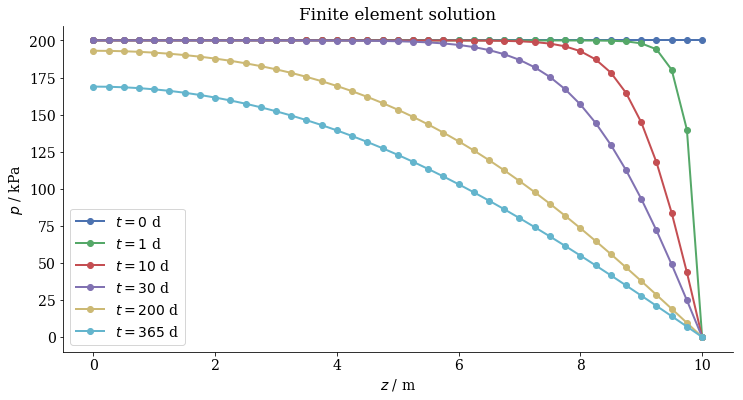

In [33]:
plt.xlabel('$z$ / m')
plt.ylabel('$p$ / kPa')
plt.title('Finite element solution')
plt.plot(nodes, sols[0]/1.e3, marker='o', label='$t = %i$ d' %(times[0]/60/60))
plt.plot(nodes, sols[1]/1.e3, marker='o', label='$t = %i$ d' %(times[1]/60/60/24))
plt.plot(nodes, sols[10]/1.e3, marker='o', label='$t = %i$ d' %(times[10]/60/60/24))
plt.plot(nodes, sols[30]/1.e3, marker='o', label='$t = %i$ d' %(times[30]/60/60/24))
plt.plot(nodes, sols[200]/1.e3, marker='o', label='$t = %i$ d' %(times[200]/60/60/24))
plt.plot(nodes, sols[-1]/1.e3, marker='o', label='$t = %i$ d' %(times[-1]/60/60/24))
plt.legend();

In [34]:
#from matplotlib import animation
#from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots();
#ax.set_xlim(( 0, 11));
#ax.set_ylim((0, 210));

#line, = ax.plot([], [], lw=2);

# initialization function: plot the background of each frame
#def init():
#    line.set_data(nodes, sols[0]/1e3)
#    return (line,)

# animation function. This is called sequentially
#def animate(i):
    #x = nodes
    #y = sols[i]/1e3
    #line.set_data(x, y)
    #return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=len(sols)-1, interval=20, blit=True);
#HTML(anim.to_html5_video())

### Convergence study with mass lumping

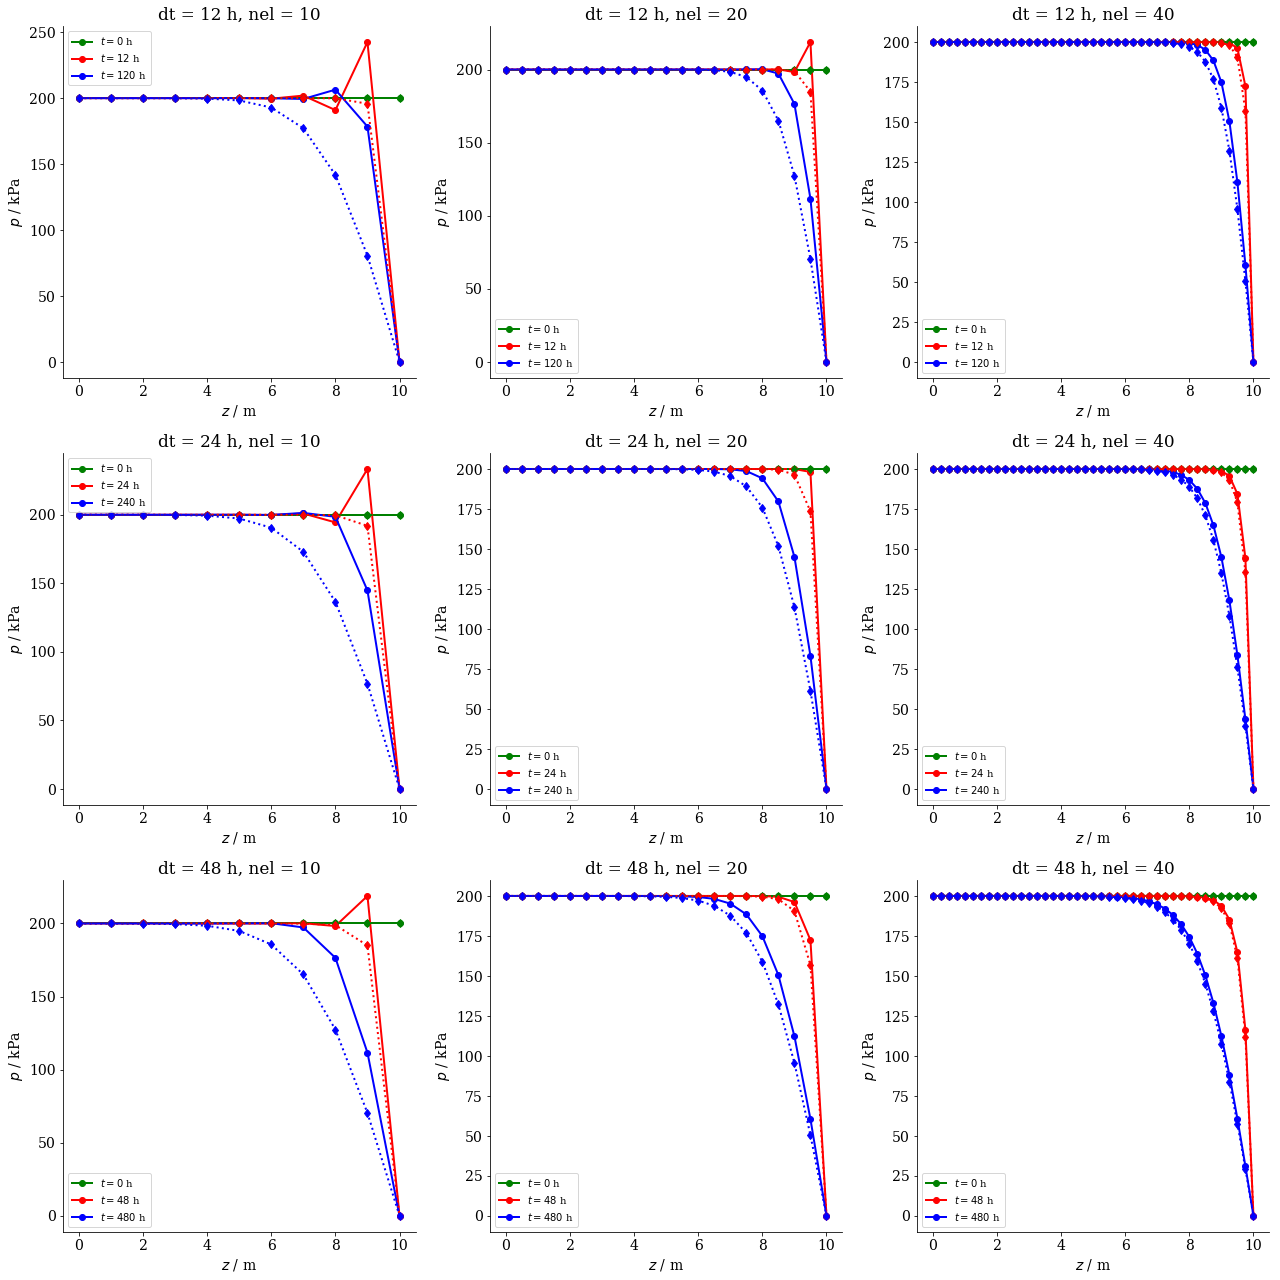

In [35]:
dts = [12.*3600,24.*3600,48.*3600]
nels = [10,20,40]
H = 10.

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(18,18))

for i,dt in enumerate(dts):
    for j,nel in enumerate(nels):
        #print("Running (n,dt) combination ", dt, nel)
        number_of_elements = nel
        nodes_per_element = 2
        nodes,elements,solution=generate_mesh(H,number_of_elements,nodes_per_element)
        times, sols, iters = time_loop(dt,nodes,elements,solution)
        nodes,elements,solution=generate_mesh(H,number_of_elements,nodes_per_element)
        #element size and random fore-factor
        times_lumped, sols_lumped, iters_lumped = time_loop(dt,nodes,elements,solution,True,False)
        #
        ax[i][j].plot(nodes, sols[0]/1.e3, marker='o', color='green', label='$t = %i$ h' %(times[0]/60/60))
        ax[i][j].plot(nodes, sols[1]/1.e3, marker='o', color='red', label='$t = %i$ h' %(times[1]/60/60))
        ax[i][j].plot(nodes, sols[10]/1.e3, marker='o', color='blue', label='$t = %i$ h' %(times[10]/60/60))
        #
        ax[i][j].plot(nodes, sols_lumped[0]/1.e3, marker='d', ls=':', color='green')
        ax[i][j].plot(nodes, sols_lumped[1]/1.e3, marker='d', ls=':', color='red')
        ax[i][j].plot(nodes, sols_lumped[10]/1.e3, marker='d', ls=':', color='blue')
        #
        ax[i][j].set_xlabel('$z$ / m')
        ax[i][j].set_ylabel('$p$ / kPa')
        ax[i][j].set_title('dt = %i h, nel = %i' %(dt/3600,nel))
        ax[i][j].legend(fontsize=10)
fig.tight_layout()

Mass lumping (dashed lines) reduces the oscillations but leads to an overly diffusive response particularly on coarse grids.

### Convergence study with FIC stabilization

In [ ]:
dts = [12.*3600,24.*3600,48.*3600]
nels = [10,20,40]
H = 10.

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(18,18))

for i,dt in enumerate(dts):
    for j,nel in enumerate(nels):
        #print("Running (n,dt) combination ", dt, nel)
        number_of_elements = nel
        nodes_per_element = 2
        nodes,elements,solution=generate_mesh(H,number_of_elements,nodes_per_element)
        times, sols, iters = time_loop(dt,nodes,elements,solution)
        nodes,elements,solution=generate_mesh(H,number_of_elements,nodes_per_element)
        #element size and random fore-factor
        times_lumped, sols_lumped, iters_lumped = time_loop(dt,nodes,elements,solution,False,True)
        #
        ax[i][j].plot(nodes, sols[0]/1.e3, marker='o', color='green', label='$t = %i$ h' %(times[0]/60/60))
        ax[i][j].plot(nodes, sols[1]/1.e3, marker='o', color='red', label='$t = %i$ h' %(times[1]/60/60))
        ax[i][j].plot(nodes, sols[10]/1.e3, marker='o', color='blue', label='$t = %i$ h' %(times[10]/60/60))
        #
        ax[i][j].plot(nodes, sols_lumped[0]/1.e3, marker='d', ls=':', color='green')
        ax[i][j].plot(nodes, sols_lumped[1]/1.e3, marker='d', ls=':', color='red')
        ax[i][j].plot(nodes, sols_lumped[10]/1.e3, marker='d', ls=':', color='blue')
        #
        ax[i][j].set_xlabel('$z$ / m')
        ax[i][j].set_ylabel('$p$ / kPa')
        ax[i][j].set_title('dt = %i h, nel = %i' %(dt/3600,nel))
        ax[i][j].legend(fontsize=10)
fig.tight_layout()

The FIC stabilization (dashed lines) reduces the oscillations and causes less artificial diffusion compared to  mass lumping.